# Basic Usage


## Climate indicator computations

`xclim` is a library of climate indicators that operate on [xarray](https://xarray.pydata.org/) `DataArray` objects. 

`xclim` provides two layers of computations, one responsible for computations and units checking (the computation layer, the **indices**), and the other responsible for input health checks and metadata formatting (the CF layer, refering to the Climate and Forecast convention, the **indicators**). Functions from the computation layer are found in `xclim.indices`, while indicator objects from the CF layer are found in *realm* modules (`xclim.atmos`, `xclim.land` and `xclim.seaIce`). 

To use xclim in a project, import both `xclim` and `xarray`. 

In [1]:
import xclim
import xarray as xr

Indice calculations are performed by opening a netCDF file, accessing the variable of interest, and calling the indice function, which returns a new DataArray. 

For this example, we'll first open a demonstration dataset storing surface air temperature and compute the number of growing degree days (the sum of degrees above a certain threshold) at the monthly frequency. 

In [2]:
# ds = xr.open_dataset("your_file.nc")
ds = xr.tutorial.open_dataset('air_temperature')
ds

<xarray.Dataset>
Dimensions:  (lat: 25, lon: 53, time: 2920)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float32 ...
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

<div class="alert alert-warning">
    
With a few exceptions, most indicators operate on daily data only. Our toy data is 6-hourly data and needs to be resampled. Resampling is explained in [xarray's](http://xarray.pydata.org/en/stable/time-series.html#resampling-and-grouped-operations) and [pandas'](https://pandas.pydata.org/docs/user_guide/timeseries.html#resampling) documentation on the subject.
    
</div>

In [3]:
daily_ds = ds.resample(time='D').mean(keep_attrs=True)
gdd = xclim.indices.growing_degree_days(tas=daily_ds.air, thresh='10.0 degC', freq='MS')
gdd

/home/tjs/miniconda3/envs/xclim38/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


<xarray.DataArray 'air' (time: 24, lat: 25, lon: 53)>
array([[[  0.     ,   0.     ,   0.     , ...,   0.     ,   0.     ,
           0.     ],
        [  0.     ,   0.     ,   0.     , ...,   0.     ,   0.     ,
           0.     ],
        [  0.     ,   0.     ,   0.     , ...,   0.     ,   0.     ,
           0.     ],
        ...,
        [393.3326 , 372.03024, 364.96753, ..., 378.77008, 363.77008,
         344.67017],
        [412.90503, 408.17755, 393.6452 , ..., 385.57   , 377.9127 ,
         363.1827 ],
        [431.00766, 430.6526 , 421.14505, ..., 407.7926 , 401.37012,
         399.56268]],

       [[  0.     ,   0.     ,   0.     , ...,   0.     ,   0.     ,
           0.     ],
        [  0.     ,   0.     ,   0.     , ...,   0.     ,   0.     ,
           0.     ],
        [  0.     ,   0.     ,   0.     , ...,   0.     ,   0.     ,
           0.     ],
...
        [446.9726 , 426.0025 , 422.16006, ..., 445.85507, 435.3075 ,
         419.8702 ],
        [474.4501 , 469.8578 , 453.64777, ..., 448.62265, 452.13257,
         442.06757],
        [480.70258, 482.0301 , 472.37274, ..., 466.99005, 467.75507,
         468.90762]],

       [[  0.     ,   0.     ,   0.     , ...,   0.     ,   0.     ,
           0.     ],
        [  0.     ,   0.     ,   0.     , ...,   0.     ,   0.     ,
           0.     ],
        [  0.     ,   0.     ,   0.     , ...,   0.     ,   0.     ,
           0.     ],
        ...,
        [412.27502, 388.78503, 390.86008, ..., 414.72766, 405.09256,
         392.5526 ],
        [443.1726 , 442.87006, 434.9852 , ..., 427.88004, 431.15753,
         420.95004],
        [461.81747, 467.35992, 462.2002 , ..., 450.9751 , 451.77002,
         451.3726 ]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2013-01-01 2013-02-01 ... 2014-12-01
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
Attributes:
    units:    C days

The call to `xclim.indices.growing_degree_days` first checked that the input variable units were units of temperature, ran the computation, then set the output's units to Celsius days. 

The `growing_degree_days` **indice** function **expects daily input**, which is why we resampled it before. The computational layer assumes that users have checked that the input data has the expected temporal frequency and has no missing values, no checks are performed, so the ouput data could be wrong. If you're unsure about all those things, a safer bet is to use **`Indicator`** objects from the CF layer, as done in the following section.

Finally, as almost all indices, the function takes a `freq` argument to specify over what time period it is computed. These are called "Offset Aliases" and are the same as the resampling string arguments. Valid arguments are detailed in [panda's doc](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases).

## Health checks and metadata attributes

Indicator instances from the CF layer are found in modules bearing the name of the computational realm in which it's input variables are found: `xclim.atmos`, `xclim.land` and `xclim.seaIce`. These objects from the CF layer run sanity checks on the input variables and set output's metadata according to CF-convention when they apply.  Some of the checks involve:

* Identifying periods where missing data significantly impacts the calculation and omits calculations for those periods. Those are called "missing methods" and are detailed in section [Health checks](../checks.rst).
* Appending process history and maintaining the historical provenance of file metadata.
* Writing [Climate and Forecast Convention](http://cfconventions.org/) compliant metadata based on the variables 
and indices calculated.

Those modules are best used for producing NetCDF that will be shared with users. See [Climate Indicators](../indicators.rst) for a list of available indicators.

If we run the `growing_degree_days` indicator over the non-resampled dataset, we'll be warned that the input data is not daily. That is, running ```xclim.atmos.growing_degree_days(ds.air, thresh='10.0 degC', freq='MS')``` will fail with a `ValidationError`:

In [5]:

gdd = xclim.atmos.growing_degree_days(ds.air, thresh='10.0 degC', freq='MS')

ValidationError: time series is not recognized as daily.

Running the same indicator with the daily data succeeds, but we still get warnings from the CF metadata checks.

In [6]:
gdd = xclim.atmos.growing_degree_days(daily_ds.air, thresh='10.0 degC', freq='MS')
gdd

/home/tjs/git/xclim/xclim/indicators/atmos/_temperature.py:69: UserWarning: Variable does not have a `cell_methods` attribute.
  cfchecks.check_valid(tas, "cell_methods", "*time: mean within days*")
/home/tjs/git/xclim/xclim/indicators/atmos/_temperature.py:70: UserWarning: Variable does not have a `standard_name` attribute.
  cfchecks.check_valid(tas, "standard_name", "air_temperature")


<xarray.DataArray 'growing_degree_days' (time: 24, lat: 25, lon: 53)>
array([[[  0.     ,   0.     ,   0.     , ...,   0.     ,   0.     ,
           0.     ],
        [  0.     ,   0.     ,   0.     , ...,   0.     ,   0.     ,
           0.     ],
        [  0.     ,   0.     ,   0.     , ...,   0.     ,   0.     ,
           0.     ],
        ...,
        [393.3326 , 372.03024, 364.96753, ..., 378.77008, 363.77008,
         344.67017],
        [412.90503, 408.17755, 393.6452 , ..., 385.57   , 377.9127 ,
         363.1827 ],
        [431.00766, 430.6526 , 421.14505, ..., 407.7926 , 401.37012,
         399.56268]],

       [[  0.     ,   0.     ,   0.     , ...,   0.     ,   0.     ,
           0.     ],
        [  0.     ,   0.     ,   0.     , ...,   0.     ,   0.     ,
           0.     ],
        [  0.     ,   0.     ,   0.     , ...,   0.     ,   0.     ,
           0.     ],
...
        [446.9726 , 426.0025 , 422.16006, ..., 445.85507, 435.3075 ,
         419.8702 ],
        [474.4501 , 469.8578 , 453.64777, ..., 448.62265, 452.13257,
         442.06757],
        [480.70258, 482.0301 , 472.37274, ..., 466.99005, 467.75507,
         468.90762]],

       [[  0.     ,   0.     ,   0.     , ...,   0.     ,   0.     ,
           0.     ],
        [  0.     ,   0.     ,   0.     , ...,   0.     ,   0.     ,
           0.     ],
        [  0.     ,   0.     ,   0.     , ...,   0.     ,   0.     ,
           0.     ],
        ...,
        [412.27502, 388.78503, 390.86008, ..., 414.72766, 405.09256,
         392.5526 ],
        [443.1726 , 442.87006, 434.9852 , ..., 427.88004, 431.15753,
         420.95004],
        [461.81747, 467.35992, 462.2002 , ..., 450.9751 , 451.77002,
         451.3726 ]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2013-01-01 2013-02-01 ... 2014-12-01
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
Attributes:
    units:          K days
    cell_methods:    time: mean within days time: sum over days
    xclim_history:  [2021-01-21 17:20:04] growing_degree_days: growing_degree...
    standard_name:  integral_of_air_temperature_excess_wrt_time
    long_name:      Growing degree days above 10.0 degc
    description:    Monthly growing degree days above 10.0 degc

To suppress the CF validation warnings in the following, we will set xclim to send them to the log, instead of raising a warning or an error.

The missing method which determines if a period should be considered missing or not can be controlled through the `check_missing` option, globally or contextually. The main missing methods also have options that can be modified.

In [7]:
with xclim.set_options(check_missing='pct', missing_options={'pct': dict(tolerance=0.1)}, cf_compliance='log'):
    # Change the missing method to "percent", instead of the default "any"
    # Set the tolerance to 10%, periods with more than 10% of missing data
    #     in the input will be masked in the ouput.
    gdd = xclim.atmos.growing_degree_days(daily_ds.air, thresh='10.0 degC', freq='MS')

/home/tjs/miniconda3/envs/xclim38/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


Finally, xclim also allows to call indicators using datasets and variable names.

In [8]:
with xclim.set_options(cf_compliance='log'):
    gdd = xclim.atmos.growing_degree_days(tas='air', thresh='10.0 degC', freq='MS', ds=daily_ds)

    # variable names default to xclim names, so we can even do this:
    renamed_daily_ds = daily_ds.rename(air='tas')
    gdd = xclim.atmos.growing_degree_days(thresh='10.0 degC', freq='MS', ds=renamed_daily_ds)

/home/tjs/miniconda3/envs/xclim38/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


## Graphics

(array([15532.,  2079.,  1861.,  1935.,  2137.,  2416.,  2675.,  2202.,
          931.,    32.]),
 array([  0.     ,  66.32573, 132.65146, 198.9772 , 265.30292, 331.62866,
        397.9544 , 464.28012, 530.60583, 596.9316 , 663.2573 ],
       dtype=float32),
 <a list of 10 Patch objects>)

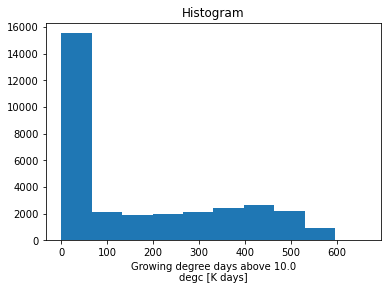

In [9]:
import matplotlib.pyplot
%matplotlib inline

# Summary statistics histogram
gdd.plot()

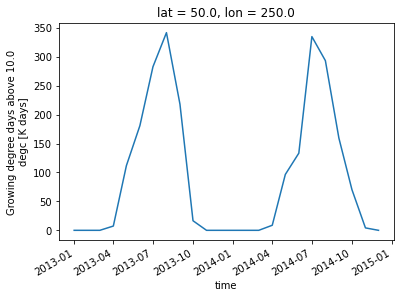

In [10]:
# Show time series at a given geographical coordinate
gdd.isel(lon=20, lat=10).plot()

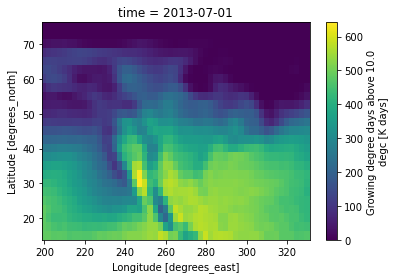

In [11]:
# Show spatial pattern at a specific time period
gdd.sel(time='2013-07').plot()

For more examples, see the directions suggested by [xarray's plotting documentation](https://xarray.pydata.org/en/stable/plotting.html>)

To save the data as a new NetCDF, use `to_netcdf`.

In [12]:
gdd.to_netcdf('monthly_growing_degree_days_data.nc')

<div class="alert alert-info">
    
It's possible to save Dataset objects to other file formats. For more information see: [xarray's documentation](https://xarray.pydata.org/en/stable/generated/xarray.Dataset.html)

</div>